In [1]:
import os

import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, completeness_score,
                             homogeneity_score, mean_absolute_error,
                             normalized_mutual_info_score, r2_score,
                             silhouette_score)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

name = "Huber"

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from VAE_GDSC import GDSCDataset, GeneDrugVAE

In [3]:
cellline = pd.read_csv(
    "../dataset/gdsc/cellline_info.csv.gz",
    usecols=["COSMIC_ID", "SMILES", "NAME", "Z_score"],
)
exp = pd.read_csv("../dataset/gdsc/exp.csv.gz", index_col=0)

In [4]:
# 学習済みモデルの指定（ChemBERTa）
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# GPUが使える場合はGPUに
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
smiles_list = cellline["SMILES"].unique().tolist()

inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

In [6]:
drugs = pd.DataFrame(embeddings.cpu().numpy())
drugs.index = smiles_list

In [7]:
exp.index = exp.index.astype(str)
cellline["COSMIC_ID"] = cellline["COSMIC_ID"].astype(str)
drugs.index = drugs.index.astype(str)

In [8]:
exp_values = exp.to_numpy(dtype=np.float32)
cid_to_row = {cid: i for i, cid in enumerate(exp.index)}
drug_vec = {s: drugs.loc[s].to_numpy(dtype=np.float32) for s in drugs.index}
mask = cellline["COSMIC_ID"].isin(exp.index) & cellline["SMILES"].isin(drugs.index)
cellline_small = cellline.loc[mask].reset_index(drop=True)
print(f"usable pairs: {len(cellline_small):,} / {len(cellline):,}")

usable pairs: 284,826 / 284,826


In [9]:
print("n_sample:", cellline_small.shape[0])

n_sample: 284826


In [10]:
# そのまま/変更案
batch_size = 16384
num_epochs = 100

# まずはこのセットで様子見（20–30 epoch）
rec_w = 0.2  # 再構成の重みをさらに下げる
lam = 3.0  # 10.0 → 3.0（目安: 2〜5）
beta_max = 1.0  # KLを抑える項は一旦オフ
gamma = 2.0  # C に寄せる圧を強化（いまの4倍）

C_max = 0.05  # 0.10 → 0.05
C_steps = 200  # 100 → 200

lr = 1e-3
weight_decay = 1e-3

In [11]:
ds = GDSCDataset(
    cellline_small,
    exp_values,
    cid_to_row,
    drug_vec,
    dtype=torch.float32,
    pin_memory=True,
    copy_arrays=False,
    #     materialize="none",    # ← これが重要！前展開を完全禁止
    #     ram_limit_gb=0.5       # （任意）auto を使う時の安全枠も小さくできる
)

In [12]:
val_ratio = 0.2
n_total = len(ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# 再現性
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=g)

In [13]:
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,  # GPU メモリに合わせて調整（8k〜32k 目安）
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True,
)

In [14]:
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,  # 余裕があれば少し大きめ
    shuffle=False,  # 検証はシャッフル不要
    num_workers=1,  # ここは少なめでもOK
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=False,
)

In [15]:
gene_dim = exp_values.shape[1]
smiles_dim = 768

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
)
device_type = (
    "cuda" if device.type == "cuda" else ("mps" if device.type == "mps" else "cpu")
)

use_amp = device_type in ("cuda", "mps")

# GradScaler は CUDA のみ
scaler = torch.amp.GradScaler(enabled=(device_type == "cuda"))

In [16]:
os.makedirs("models/gdsc", exist_ok=True)

best_val = float("inf")
best_path = f"models/gdsc/gdsc_best_{name}.pt"

# --- logs / histories ---
train_hist, val_hist, elbo_val_hist = [], [], []
train_rec_hist, train_kl_hist, train_z_hist = [], [], []
val_rec_hist, val_kl_hist, val_z_hist = [], [], []
train_capgap_hist, val_capgap_hist, C_values = [], [], []

model = GeneDrugVAE(
    gene_dim, drug_dim=smiles_dim, proj_dim=256, hidden=512, latent=128
).to(device)

# 1) Optimizer を param group で作り直し
head_params = list(model.head.parameters())
base_params = [p for n, p in model.named_parameters() if not n.startswith("head.")]

opt = torch.optim.Adam(
    [
        {"params": base_params, "lr": lr, "weight_decay": 1e-3},
        {"params": head_params, "lr": lr * 0.5, "weight_decay": 5e-3},  # ← LR↓, WD↑
    ]
)


def _avg(sum_val, cnt):
    return sum_val / max(cnt, 1)


beta_warmup_epochs = int(0.5 * num_epochs)
for ep in range(num_epochs):
    # === 追加：このepochのβ（0→1に線形） ===
    beta = beta_max * min(1.0, (ep + 1) / beta_warmup_epochs)

    model.train()
    C = C_max * (ep / C_steps) if ep < C_steps else C_max
    C_values.append(C)

    # ---- training ----
    m_total = n_batches = 0
    rec_sum = kl_sum = z_sum = capgap_sum = 0.0
    n_train_samples = 0

    for bidx, (xg, xd, y) in enumerate(
        tqdm(train_dl, desc=f"Train E{ep+1}", leave=False)
    ):
        if ep == 0 and bidx == 0:
            print(
                f"[LR] base={opt.param_groups[0]['lr']:.2e} | head={opt.param_groups[1]['lr']:.2e}"
            )

        xg = xg.to(device, non_blocking=True)
        xd = xd.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=use_amp):
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)
            gap_sq = (kl - C) ** 2
            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss

        if device_type == "cuda":
            prev_scale = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)  # ← これを追加してからクリップ
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        bs = xg.size(0)
        m_total += loss.item()
        n_batches += 1
        rec_sum += rec.item() * bs
        kl_sum += kl.item() * bs
        z_sum += zloss.item() * bs
        capgap_sum += gap_abs.item() * bs
        n_train_samples += bs

    train_loss = m_total / n_batches
    train_hist.append(train_loss)
    train_rec_hist.append(_avg(rec_sum, n_train_samples))
    train_kl_hist.append(_avg(kl_sum, n_train_samples))
    train_z_hist.append(_avg(z_sum, n_train_samples))
    train_capgap_hist.append(_avg(capgap_sum, n_train_samples))

    # ---- validation ----
    model.eval()
    val_loss_sum = 0.0
    n_val_batches = 0
    v_rec_sum = v_kl_sum = v_z_sum = v_capgap_sum = 0.0
    n_val_samples = 0
    elbo_val_sum = 0.0

    with torch.no_grad():
        for xg, xd, y in val_dl:
            xg, xd, y = xg.to(device), xd.to(device), y.to(device)
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)  # ← 追加：ログ用
            gap_sq = (kl - C) ** 2  # ← 追加：損失用（二乗）

            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss
            elbo_loss = rec + beta * kl + lam * zloss

            bs = xg.size(0)
            val_loss_sum += loss.item()
            n_val_batches += 1
            v_rec_sum += rec.item() * bs
            v_kl_sum += kl.item() * bs
            v_z_sum += zloss.item() * bs
            v_capgap_sum += gap_abs.item() * bs  # ← 置換：capgap → gap_abs
            n_val_samples += bs
            elbo_val_sum += elbo_loss.item() * bs

    val_loss = val_loss_sum / n_val_batches
    val_hist.append(val_loss)
    val_rec_hist.append(_avg(v_rec_sum, n_val_samples))
    val_kl_hist.append(_avg(v_kl_sum, n_val_samples))
    val_z_hist.append(_avg(v_z_sum, n_val_samples))
    val_capgap_hist.append(_avg(v_capgap_sum, n_val_samples))
    elbo_val_hist.append(_avg(elbo_val_sum, n_val_samples))

    print(
        f"Epoch {ep+1}/{num_epochs} | Train {train_loss:.4f} | Val {val_loss:.4f} | Val(ELBO) {elbo_val_hist[-1]:.4f}"
    )

    print(
        f"  C={C:.3f} | "
        f"KL tr/val={train_kl_hist[-1]:.4f}/{val_kl_hist[-1]:.4f} | "
        f"gap(|KL-C|) tr/val={train_capgap_hist[-1]:.4f}/{val_capgap_hist[-1]:.4f} | "
        f"zloss tr/val={train_z_hist[-1]:.4f}/{val_z_hist[-1]:.4f} | "
        f"rec tr/val={train_rec_hist[-1]:.4f}/{val_rec_hist[-1]:.4f} | "
        f"beta={beta:.4f}, gamma={gamma:.4f}"
    )

    if (ep + 1) % 10 == 0:
        model.eval()
        eval_dl = torch.utils.data.DataLoader(
            val_ds,
            batch_size=8192,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            persistent_workers=False,
            drop_last=False,
        )
        ys, yhats = [], []
        with torch.inference_mode():
            for xg, xd, y in eval_dl:
                xg, xd = xg.to(device), xd.to(device)
                _, _, _, yhat = model(xg, xd)
                ys.append(y.cpu().numpy())
                yhats.append(yhat.cpu().numpy())
        import numpy as np
        from sklearn.metrics import mean_absolute_error, r2_score

        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        mae = mean_absolute_error(ys, yhats)
        r2 = r2_score(ys, yhats)
        print(f"  [Eval@E{ep+1}] MAE={mae:.4f}, R^2={r2:.4f}")
        print(f"  [Eval@E{ep+1}] yhat mean/std = {yhats.mean():.4f}/{yhats.std():.4f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f"[Save] Best model updated at epoch {ep+1}: {best_path}")

Train E1:   0%|          | 0/13 [00:00<?, ?it/s]

[LR] base=1.00e-03 | head=5.00e-04


Epoch 1/100 | Train 1.4319 | Val 1.3735 | Val(ELBO) 2.1715
  C=0.000 | KL tr/val=0.0959/0.0883 | gap(|KL-C|) tr/val=0.0959/0.0883 | zloss tr/val=0.3998/0.3847 | rec tr/val=1.0336/1.0158 | beta=0.0200, gamma=2.0000
[Save] Best model updated at epoch 1: models/gdsc/gdsc_best_Huber.pt


Epoch 2/100 | Train 1.3377 | Val 1.3157 | Val(ELBO) 2.1120
  C=0.000 | KL tr/val=0.0964/0.0607 | gap(|KL-C|) tr/val=0.0962/0.0604 | zloss tr/val=0.3704/0.3685 | rec tr/val=1.0090/1.0040 | beta=0.0400, gamma=2.0000
[Save] Best model updated at epoch 2: models/gdsc/gdsc_best_Huber.pt


Epoch 3/100 | Train 1.2757 | Val 1.2531 | Val(ELBO) 2.0310
  C=0.001 | KL tr/val=0.1001/0.1088 | gap(|KL-C|) tr/val=0.0996/0.1083 | zloss tr/val=0.3495/0.3412 | rec tr/val=1.0022/1.0007 | beta=0.0600, gamma=2.0000
[Save] Best model updated at epoch 3: models/gdsc/gdsc_best_Huber.pt


Epoch 4/100 | Train 1.2282 | Val 1.2282 | Val(ELBO) 2.0122
  C=0.001 | KL tr/val=0.0943/0.0904 | gap(|KL-C|) tr/val=0.0936/0.0897 | zloss tr/val=0.3343/0.3350 | rec tr/val=1.0002/0.9999 | beta=0.0800, gamma=2.0000
[Save] Best model updated at epoch 4: models/gdsc/gdsc_best_Huber.pt


Epoch 5/100 | Train 1.2077 | Val 1.2077 | Val(ELBO) 1.9983
  C=0.001 | KL tr/val=0.0766/0.0697 | gap(|KL-C|) tr/val=0.0756/0.0687 | zloss tr/val=0.3295/0.3305 | rec tr/val=0.9997/0.9997 | beta=0.1000, gamma=2.0000
[Save] Best model updated at epoch 5: models/gdsc/gdsc_best_Huber.pt


Epoch 6/100 | Train 1.1943 | Val 1.1974 | Val(ELBO) 1.9897
  C=0.001 | KL tr/val=0.0644/0.0617 | gap(|KL-C|) tr/val=0.0632/0.0604 | zloss tr/val=0.3262/0.3275 | rec tr/val=0.9995/0.9997 | beta=0.1200, gamma=2.0000
[Save] Best model updated at epoch 6: models/gdsc/gdsc_best_Huber.pt


Epoch 7/100 | Train 1.1821 | Val 1.1863 | Val(ELBO) 1.9784
  C=0.002 | KL tr/val=0.0584/0.0656 | gap(|KL-C|) tr/val=0.0569/0.0641 | zloss tr/val=0.3225/0.3232 | rec tr/val=0.9996/0.9997 | beta=0.1400, gamma=2.0000
[Save] Best model updated at epoch 7: models/gdsc/gdsc_best_Huber.pt


Epoch 8/100 | Train 1.1681 | Val 1.1698 | Val(ELBO) 1.9664
  C=0.002 | KL tr/val=0.0557/0.0452 | gap(|KL-C|) tr/val=0.0540/0.0434 | zloss tr/val=0.3178/0.3198 | rec tr/val=0.9997/0.9997 | beta=0.1600, gamma=2.0000
[Save] Best model updated at epoch 8: models/gdsc/gdsc_best_Huber.pt


Epoch 9/100 | Train 1.1734 | Val 1.1738 | Val(ELBO) 1.9672
  C=0.002 | KL tr/val=0.0500/0.0617 | gap(|KL-C|) tr/val=0.0480/0.0597 | zloss tr/val=0.3199/0.3188 | rec tr/val=0.9995/0.9997 | beta=0.1800, gamma=2.0000


Epoch 10/100 | Train 1.1512 | Val 1.1559 | Val(ELBO) 1.9522
  C=0.002 | KL tr/val=0.0491/0.0478 | gap(|KL-C|) tr/val=0.0468/0.0455 | zloss tr/val=0.3123/0.3143 | rec tr/val=0.9995/0.9997 | beta=0.2000, gamma=2.0000
  [Eval@E10] MAE=0.6589, R^2=0.2603
  [Eval@E10] yhat mean/std = 0.0485/0.4757
[Save] Best model updated at epoch 10: models/gdsc/gdsc_best_Huber.pt


Epoch 11/100 | Train 1.1394 | Val 1.1644 | Val(ELBO) 1.9604
  C=0.003 | KL tr/val=0.0460/0.0479 | gap(|KL-C|) tr/val=0.0435/0.0454 | zloss tr/val=0.3085/0.3167 | rec tr/val=0.9995/0.9997 | beta=0.2200, gamma=2.0000


Epoch 12/100 | Train 1.1335 | Val 1.1347 | Val(ELBO) 1.9332
  C=0.003 | KL tr/val=0.0434/0.0338 | gap(|KL-C|) tr/val=0.0406/0.0311 | zloss tr/val=0.3066/0.3084 | rec tr/val=0.9997/0.9997 | beta=0.2400, gamma=2.0000
[Save] Best model updated at epoch 12: models/gdsc/gdsc_best_Huber.pt


Epoch 13/100 | Train 1.1149 | Val 1.1251 | Val(ELBO) 1.9224
  C=0.003 | KL tr/val=0.0410/0.0364 | gap(|KL-C|) tr/val=0.0380/0.0334 | zloss tr/val=0.3005/0.3044 | rec tr/val=0.9992/0.9997 | beta=0.2600, gamma=2.0000
[Save] Best model updated at epoch 13: models/gdsc/gdsc_best_Huber.pt


Epoch 14/100 | Train 1.1194 | Val 1.1265 | Val(ELBO) 1.9252
  C=0.003 | KL tr/val=0.0386/0.0300 | gap(|KL-C|) tr/val=0.0353/0.0267 | zloss tr/val=0.3020/0.3057 | rec tr/val=0.9998/0.9997 | beta=0.2800, gamma=2.0000


Epoch 15/100 | Train 1.1023 | Val 1.1093 | Val(ELBO) 1.9074
  C=0.004 | KL tr/val=0.0366/0.0355 | gap(|KL-C|) tr/val=0.0331/0.0320 | zloss tr/val=0.2964/0.2990 | rec tr/val=0.9995/0.9997 | beta=0.3000, gamma=2.0000
[Save] Best model updated at epoch 15: models/gdsc/gdsc_best_Huber.pt


Epoch 16/100 | Train 1.0994 | Val 1.1065 | Val(ELBO) 1.9050
  C=0.004 | KL tr/val=0.0351/0.0307 | gap(|KL-C|) tr/val=0.0314/0.0270 | zloss tr/val=0.2954/0.2985 | rec tr/val=0.9997/0.9997 | beta=0.3200, gamma=2.0000
[Save] Best model updated at epoch 16: models/gdsc/gdsc_best_Huber.pt


Epoch 17/100 | Train 1.0882 | Val 1.1012 | Val(ELBO) 1.8993
  C=0.004 | KL tr/val=0.0333/0.0290 | gap(|KL-C|) tr/val=0.0293/0.0250 | zloss tr/val=0.2917/0.2966 | rec tr/val=0.9997/0.9997 | beta=0.3400, gamma=2.0000
[Save] Best model updated at epoch 17: models/gdsc/gdsc_best_Huber.pt


Epoch 18/100 | Train 1.0894 | Val 1.1274 | Val(ELBO) 1.9266
  C=0.004 | KL tr/val=0.0323/0.0232 | gap(|KL-C|) tr/val=0.0281/0.0190 | zloss tr/val=0.2921/0.3062 | rec tr/val=0.9995/0.9997 | beta=0.3600, gamma=2.0000


Epoch 19/100 | Train 1.0993 | Val 1.1006 | Val(ELBO) 1.8990
  C=0.004 | KL tr/val=0.0289/0.0297 | gap(|KL-C|) tr/val=0.0244/0.0252 | zloss tr/val=0.2957/0.2960 | rec tr/val=0.9997/0.9997 | beta=0.3800, gamma=2.0000
[Save] Best model updated at epoch 19: models/gdsc/gdsc_best_Huber.pt


Epoch 20/100 | Train 1.0784 | Val 1.0924 | Val(ELBO) 1.8909
  C=0.005 | KL tr/val=0.0300/0.0277 | gap(|KL-C|) tr/val=0.0252/0.0229 | zloss tr/val=0.2884/0.2934 | rec tr/val=0.9996/0.9997 | beta=0.4000, gamma=2.0000
  [Eval@E20] MAE=0.6290, R^2=0.3125
  [Eval@E20] yhat mean/std = 0.0316/0.5307
[Save] Best model updated at epoch 20: models/gdsc/gdsc_best_Huber.pt


Epoch 21/100 | Train 1.0665 | Val 1.0858 | Val(ELBO) 1.8845
  C=0.005 | KL tr/val=0.0285/0.0301 | gap(|KL-C|) tr/val=0.0235/0.0251 | zloss tr/val=0.2845/0.2907 | rec tr/val=0.9993/0.9997 | beta=0.4200, gamma=2.0000
[Save] Best model updated at epoch 21: models/gdsc/gdsc_best_Huber.pt


Epoch 22/100 | Train 1.0600 | Val 1.0788 | Val(ELBO) 1.8782
  C=0.005 | KL tr/val=0.0278/0.0219 | gap(|KL-C|) tr/val=0.0226/0.0167 | zloss tr/val=0.2823/0.2896 | rec tr/val=0.9995/0.9997 | beta=0.4400, gamma=2.0000
[Save] Best model updated at epoch 22: models/gdsc/gdsc_best_Huber.pt


Epoch 23/100 | Train 1.0574 | Val 1.0769 | Val(ELBO) 1.8763
  C=0.006 | KL tr/val=0.0254/0.0279 | gap(|KL-C|) tr/val=0.0199/0.0224 | zloss tr/val=0.2817/0.2879 | rec tr/val=0.9994/0.9997 | beta=0.4600, gamma=2.0000
[Save] Best model updated at epoch 23: models/gdsc/gdsc_best_Huber.pt


Epoch 24/100 | Train 1.0482 | Val 1.0583 | Val(ELBO) 1.8574
  C=0.006 | KL tr/val=0.0254/0.0242 | gap(|KL-C|) tr/val=0.0196/0.0185 | zloss tr/val=0.2784/0.2820 | rec tr/val=0.9997/0.9997 | beta=0.4800, gamma=2.0000
[Save] Best model updated at epoch 24: models/gdsc/gdsc_best_Huber.pt


Epoch 25/100 | Train 1.0350 | Val 1.0507 | Val(ELBO) 1.8499
  C=0.006 | KL tr/val=0.0251/0.0232 | gap(|KL-C|) tr/val=0.0191/0.0172 | zloss tr/val=0.2739/0.2795 | rec tr/val=0.9997/0.9997 | beta=0.5000, gamma=2.0000
[Save] Best model updated at epoch 25: models/gdsc/gdsc_best_Huber.pt


Epoch 26/100 | Train 1.0358 | Val 1.0460 | Val(ELBO) 1.8452
  C=0.006 | KL tr/val=0.0234/0.0193 | gap(|KL-C|) tr/val=0.0171/0.0130 | zloss tr/val=0.2744/0.2785 | rec tr/val=0.9997/0.9997 | beta=0.5200, gamma=2.0000
[Save] Best model updated at epoch 26: models/gdsc/gdsc_best_Huber.pt


Epoch 27/100 | Train 1.0336 | Val 1.0527 | Val(ELBO) 1.8525
  C=0.007 | KL tr/val=0.0231/0.0214 | gap(|KL-C|) tr/val=0.0166/0.0149 | zloss tr/val=0.2736/0.2804 | rec tr/val=0.9994/0.9997 | beta=0.5400, gamma=2.0000


Epoch 28/100 | Train 1.0207 | Val 1.0453 | Val(ELBO) 1.8438
  C=0.007 | KL tr/val=0.0228/0.0220 | gap(|KL-C|) tr/val=0.0161/0.0153 | zloss tr/val=0.2692/0.2773 | rec tr/val=0.9995/0.9997 | beta=0.5600, gamma=2.0000
[Save] Best model updated at epoch 28: models/gdsc/gdsc_best_Huber.pt


Epoch 29/100 | Train 1.0155 | Val 1.0380 | Val(ELBO) 1.8372
  C=0.007 | KL tr/val=0.0227/0.0174 | gap(|KL-C|) tr/val=0.0157/0.0104 | zloss tr/val=0.2673/0.2758 | rec tr/val=0.9995/0.9997 | beta=0.5800, gamma=2.0000
[Save] Best model updated at epoch 29: models/gdsc/gdsc_best_Huber.pt


Epoch 30/100 | Train 1.0088 | Val 1.0252 | Val(ELBO) 1.8250
  C=0.007 | KL tr/val=0.0222/0.0199 | gap(|KL-C|) tr/val=0.0150/0.0126 | zloss tr/val=0.2650/0.2711 | rec tr/val=0.9996/0.9997 | beta=0.6000, gamma=2.0000
  [Eval@E30] MAE=0.5981, R^2=0.3688
  [Eval@E30] yhat mean/std = 0.0222/0.5935
[Save] Best model updated at epoch 30: models/gdsc/gdsc_best_Huber.pt


Epoch 31/100 | Train 0.9952 | Val 1.0299 | Val(ELBO) 1.8293
  C=0.007 | KL tr/val=0.0219/0.0166 | gap(|KL-C|) tr/val=0.0144/0.0091 | zloss tr/val=0.2604/0.2731 | rec tr/val=0.9996/0.9997 | beta=0.6200, gamma=2.0000


Epoch 32/100 | Train 0.9915 | Val 1.0189 | Val(ELBO) 1.8185
  C=0.008 | KL tr/val=0.0203/0.0169 | gap(|KL-C|) tr/val=0.0126/0.0092 | zloss tr/val=0.2594/0.2693 | rec tr/val=0.9996/0.9997 | beta=0.6400, gamma=2.0000
[Save] Best model updated at epoch 32: models/gdsc/gdsc_best_Huber.pt


Epoch 33/100 | Train 0.9859 | Val 1.0196 | Val(ELBO) 1.8193
  C=0.008 | KL tr/val=0.0197/0.0183 | gap(|KL-C|) tr/val=0.0117/0.0103 | zloss tr/val=0.2576/0.2692 | rec tr/val=0.9994/0.9997 | beta=0.6600, gamma=2.0000


Epoch 34/100 | Train 0.9819 | Val 1.0320 | Val(ELBO) 1.8315
  C=0.008 | KL tr/val=0.0204/0.0163 | gap(|KL-C|) tr/val=0.0121/0.0080 | zloss tr/val=0.2559/0.2736 | rec tr/val=0.9997/0.9997 | beta=0.6800, gamma=2.0000


Epoch 35/100 | Train 0.9828 | Val 1.0078 | Val(ELBO) 1.8078
  C=0.009 | KL tr/val=0.0194/0.0173 | gap(|KL-C|) tr/val=0.0109/0.0088 | zloss tr/val=0.2564/0.2653 | rec tr/val=0.9994/0.9997 | beta=0.7000, gamma=2.0000
[Save] Best model updated at epoch 35: models/gdsc/gdsc_best_Huber.pt


Epoch 36/100 | Train 0.9715 | Val 1.0015 | Val(ELBO) 1.8017
  C=0.009 | KL tr/val=0.0186/0.0157 | gap(|KL-C|) tr/val=0.0098/0.0069 | zloss tr/val=0.2526/0.2636 | rec tr/val=0.9997/0.9997 | beta=0.7200, gamma=2.0000
[Save] Best model updated at epoch 36: models/gdsc/gdsc_best_Huber.pt


Epoch 37/100 | Train 0.9682 | Val 1.0010 | Val(ELBO) 1.8004
  C=0.009 | KL tr/val=0.0181/0.0177 | gap(|KL-C|) tr/val=0.0091/0.0087 | zloss tr/val=0.2516/0.2625 | rec tr/val=0.9995/0.9997 | beta=0.7400, gamma=2.0000
[Save] Best model updated at epoch 37: models/gdsc/gdsc_best_Huber.pt


Epoch 38/100 | Train 0.9633 | Val 1.0054 | Val(ELBO) 1.8062
  C=0.009 | KL tr/val=0.0200/0.0155 | gap(|KL-C|) tr/val=0.0108/0.0063 | zloss tr/val=0.2493/0.2649 | rec tr/val=0.9998/0.9997 | beta=0.7600, gamma=2.0000


Epoch 39/100 | Train 0.9565 | Val 0.9890 | Val(ELBO) 1.7885
  C=0.010 | KL tr/val=0.0190/0.0162 | gap(|KL-C|) tr/val=0.0095/0.0067 | zloss tr/val=0.2472/0.2587 | rec tr/val=0.9997/0.9997 | beta=0.7800, gamma=2.0000
[Save] Best model updated at epoch 39: models/gdsc/gdsc_best_Huber.pt


Epoch 40/100 | Train 0.9500 | Val 1.0001 | Val(ELBO) 1.7995
  C=0.010 | KL tr/val=0.0204/0.0153 | gap(|KL-C|) tr/val=0.0107/0.0056 | zloss tr/val=0.2445/0.2625 | rec tr/val=0.9991/0.9997 | beta=0.8000, gamma=2.0000
  [Eval@E40] MAE=0.5849, R^2=0.3868
  [Eval@E40] yhat mean/std = 0.1243/0.6224


Epoch 41/100 | Train 0.9443 | Val 0.9878 | Val(ELBO) 1.7880
  C=0.010 | KL tr/val=0.0181/0.0151 | gap(|KL-C|) tr/val=0.0081/0.0051 | zloss tr/val=0.2431/0.2586 | rec tr/val=1.0001/0.9997 | beta=0.8200, gamma=2.0000
[Save] Best model updated at epoch 41: models/gdsc/gdsc_best_Huber.pt


Epoch 42/100 | Train 0.9410 | Val 0.9842 | Val(ELBO) 1.7845
  C=0.010 | KL tr/val=0.0169/0.0135 | gap(|KL-C|) tr/val=0.0066/0.0032 | zloss tr/val=0.2423/0.2578 | rec tr/val=0.9996/0.9997 | beta=0.8400, gamma=2.0000
[Save] Best model updated at epoch 42: models/gdsc/gdsc_best_Huber.pt


Epoch 43/100 | Train 0.9364 | Val 0.9827 | Val(ELBO) 1.7833
  C=0.011 | KL tr/val=0.0158/0.0152 | gap(|KL-C|) tr/val=0.0053/0.0047 | zloss tr/val=0.2409/0.2569 | rec tr/val=0.9996/0.9997 | beta=0.8600, gamma=2.0000
[Save] Best model updated at epoch 43: models/gdsc/gdsc_best_Huber.pt


Epoch 44/100 | Train 0.9465 | Val 0.9903 | Val(ELBO) 1.7907
  C=0.011 | KL tr/val=0.0174/0.0126 | gap(|KL-C|) tr/val=0.0066/0.0019 | zloss tr/val=0.2437/0.2600 | rec tr/val=0.9996/0.9997 | beta=0.8800, gamma=2.0000


Epoch 45/100 | Train 0.9372 | Val 0.9749 | Val(ELBO) 1.7743
  C=0.011 | KL tr/val=0.0183/0.0142 | gap(|KL-C|) tr/val=0.0073/0.0032 | zloss tr/val=0.2402/0.2540 | rec tr/val=0.9996/0.9997 | beta=0.9000, gamma=2.0000
[Save] Best model updated at epoch 45: models/gdsc/gdsc_best_Huber.pt


Epoch 46/100 | Train 0.9297 | Val 0.9997 | Val(ELBO) 1.7990
  C=0.011 | KL tr/val=0.0191/0.0129 | gap(|KL-C|) tr/val=0.0078/0.0016 | zloss tr/val=0.2374/0.2625 | rec tr/val=0.9995/0.9997 | beta=0.9200, gamma=2.0000


Epoch 47/100 | Train 0.9264 | Val 0.9666 | Val(ELBO) 1.7667
  C=0.012 | KL tr/val=0.0140/0.0144 | gap(|KL-C|) tr/val=0.0026/0.0029 | zloss tr/val=0.2378/0.2511 | rec tr/val=0.9995/0.9997 | beta=0.9400, gamma=2.0000
[Save] Best model updated at epoch 47: models/gdsc/gdsc_best_Huber.pt


Epoch 48/100 | Train 0.9164 | Val 0.9748 | Val(ELBO) 1.7742
  C=0.012 | KL tr/val=0.0144/0.0143 | gap(|KL-C|) tr/val=0.0028/0.0026 | zloss tr/val=0.2342/0.2536 | rec tr/val=0.9997/0.9997 | beta=0.9600, gamma=2.0000


Epoch 49/100 | Train 0.9177 | Val 0.9663 | Val(ELBO) 1.7667
  C=0.012 | KL tr/val=0.0150/0.0124 | gap(|KL-C|) tr/val=0.0030/0.0004 | zloss tr/val=0.2344/0.2516 | rec tr/val=0.9997/0.9997 | beta=0.9800, gamma=2.0000
[Save] Best model updated at epoch 49: models/gdsc/gdsc_best_Huber.pt


Epoch 50/100 | Train 0.9166 | Val 0.9658 | Val(ELBO) 1.7660
  C=0.012 | KL tr/val=0.0171/0.0121 | gap(|KL-C|) tr/val=0.0050/0.0002 | zloss tr/val=0.2331/0.2514 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E50] MAE=0.5716, R^2=0.4210
  [Eval@E50] yhat mean/std = 0.0033/0.6342
[Save] Best model updated at epoch 50: models/gdsc/gdsc_best_Huber.pt


Epoch 51/100 | Train 0.9169 | Val 0.9639 | Val(ELBO) 1.7640
  C=0.013 | KL tr/val=0.0165/0.0135 | gap(|KL-C|) tr/val=0.0045/0.0010 | zloss tr/val=0.2335/0.2503 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 51: models/gdsc/gdsc_best_Huber.pt


Epoch 52/100 | Train 0.9118 | Val 0.9682 | Val(ELBO) 1.7679
  C=0.013 | KL tr/val=0.0157/0.0113 | gap(|KL-C|) tr/val=0.0031/0.0014 | zloss tr/val=0.2320/0.2523 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 53/100 | Train 0.9010 | Val 0.9546 | Val(ELBO) 1.7541
  C=0.013 | KL tr/val=0.0151/0.0119 | gap(|KL-C|) tr/val=0.0035/0.0011 | zloss tr/val=0.2286/0.2475 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 53: models/gdsc/gdsc_best_Huber.pt


Epoch 54/100 | Train 0.8943 | Val 0.9583 | Val(ELBO) 1.7580
  C=0.013 | KL tr/val=0.0159/0.0133 | gap(|KL-C|) tr/val=0.0038/0.0001 | zloss tr/val=0.2262/0.2483 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 55/100 | Train 0.8973 | Val 0.9640 | Val(ELBO) 1.7639
  C=0.014 | KL tr/val=0.0150/0.0115 | gap(|KL-C|) tr/val=0.0025/0.0020 | zloss tr/val=0.2275/0.2509 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 56/100 | Train 0.9003 | Val 0.9628 | Val(ELBO) 1.7626
  C=0.014 | KL tr/val=0.0154/0.0125 | gap(|KL-C|) tr/val=0.0023/0.0013 | zloss tr/val=0.2283/0.2502 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 57/100 | Train 0.8891 | Val 0.9553 | Val(ELBO) 1.7550
  C=0.014 | KL tr/val=0.0139/0.0107 | gap(|KL-C|) tr/val=0.0023/0.0033 | zloss tr/val=0.2251/0.2482 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 58/100 | Train 0.8835 | Val 0.9559 | Val(ELBO) 1.7558
  C=0.014 | KL tr/val=0.0135/0.0127 | gap(|KL-C|) tr/val=0.0021/0.0016 | zloss tr/val=0.2233/0.2478 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000


Epoch 59/100 | Train 0.8796 | Val 0.9518 | Val(ELBO) 1.7512
  C=0.014 | KL tr/val=0.0157/0.0121 | gap(|KL-C|) tr/val=0.0025/0.0024 | zloss tr/val=0.2213/0.2465 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 59: models/gdsc/gdsc_best_Huber.pt


Epoch 60/100 | Train 0.8952 | Val 0.9624 | Val(ELBO) 1.7610
  C=0.015 | KL tr/val=0.0145/0.0118 | gap(|KL-C|) tr/val=0.0035/0.0029 | zloss tr/val=0.2269/0.2498 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E60] MAE=0.5685, R^2=0.4229
  [Eval@E60] yhat mean/std = 0.1024/0.6523


Epoch 61/100 | Train 0.8868 | Val 0.9590 | Val(ELBO) 1.7578
  C=0.015 | KL tr/val=0.0163/0.0125 | gap(|KL-C|) tr/val=0.0033/0.0025 | zloss tr/val=0.2235/0.2485 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000


Epoch 62/100 | Train 0.8780 | Val 0.9510 | Val(ELBO) 1.7505
  C=0.015 | KL tr/val=0.0161/0.0113 | gap(|KL-C|) tr/val=0.0034/0.0040 | zloss tr/val=0.2207/0.2465 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 62: models/gdsc/gdsc_best_Huber.pt


Epoch 63/100 | Train 0.8746 | Val 0.9494 | Val(ELBO) 1.7491
  C=0.015 | KL tr/val=0.0147/0.0110 | gap(|KL-C|) tr/val=0.0021/0.0045 | zloss tr/val=0.2200/0.2462 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 63: models/gdsc/gdsc_best_Huber.pt


Epoch 64/100 | Train 0.8715 | Val 0.9473 | Val(ELBO) 1.7466
  C=0.016 | KL tr/val=0.0146/0.0110 | gap(|KL-C|) tr/val=0.0025/0.0047 | zloss tr/val=0.2190/0.2453 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 64: models/gdsc/gdsc_best_Huber.pt


Epoch 65/100 | Train 0.8624 | Val 0.9428 | Val(ELBO) 1.7418
  C=0.016 | KL tr/val=0.0134/0.0115 | gap(|KL-C|) tr/val=0.0038/0.0045 | zloss tr/val=0.2164/0.2435 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 65: models/gdsc/gdsc_best_Huber.pt


Epoch 66/100 | Train 0.8714 | Val 0.9440 | Val(ELBO) 1.7433
  C=0.016 | KL tr/val=0.0145/0.0113 | gap(|KL-C|) tr/val=0.0039/0.0050 | zloss tr/val=0.2190/0.2441 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 67/100 | Train 0.8641 | Val 0.9403 | Val(ELBO) 1.7396
  C=0.017 | KL tr/val=0.0149/0.0114 | gap(|KL-C|) tr/val=0.0042/0.0051 | zloss tr/val=0.2164/0.2428 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 67: models/gdsc/gdsc_best_Huber.pt


Epoch 68/100 | Train 0.8604 | Val 0.9429 | Val(ELBO) 1.7425
  C=0.017 | KL tr/val=0.0147/0.0106 | gap(|KL-C|) tr/val=0.0026/0.0061 | zloss tr/val=0.2152/0.2441 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 69/100 | Train 0.8562 | Val 0.9435 | Val(ELBO) 1.7434
  C=0.017 | KL tr/val=0.0136/0.0116 | gap(|KL-C|) tr/val=0.0038/0.0054 | zloss tr/val=0.2142/0.2440 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000


Epoch 70/100 | Train 0.8629 | Val 0.9461 | Val(ELBO) 1.7456
  C=0.017 | KL tr/val=0.0147/0.0102 | gap(|KL-C|) tr/val=0.0032/0.0071 | zloss tr/val=0.2161/0.2452 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E70] MAE=0.5625, R^2=0.4349
  [Eval@E70] yhat mean/std = 0.0806/0.6564


Epoch 71/100 | Train 0.8550 | Val 0.9583 | Val(ELBO) 1.7570
  C=0.017 | KL tr/val=0.0136/0.0116 | gap(|KL-C|) tr/val=0.0046/0.0059 | zloss tr/val=0.2138/0.2486 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 72/100 | Train 0.8505 | Val 0.9366 | Val(ELBO) 1.7354
  C=0.018 | KL tr/val=0.0149/0.0106 | gap(|KL-C|) tr/val=0.0039/0.0071 | zloss tr/val=0.2119/0.2417 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 72: models/gdsc/gdsc_best_Huber.pt


Epoch 73/100 | Train 0.8460 | Val 0.9433 | Val(ELBO) 1.7425
  C=0.018 | KL tr/val=0.0142/0.0109 | gap(|KL-C|) tr/val=0.0039/0.0071 | zloss tr/val=0.2106/0.2440 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 74/100 | Train 0.8395 | Val 0.9364 | Val(ELBO) 1.7355
  C=0.018 | KL tr/val=0.0113/0.0101 | gap(|KL-C|) tr/val=0.0069/0.0081 | zloss tr/val=0.2094/0.2419 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 74: models/gdsc/gdsc_best_Huber.pt


Epoch 75/100 | Train 0.8451 | Val 0.9425 | Val(ELBO) 1.7414
  C=0.018 | KL tr/val=0.0152/0.0106 | gap(|KL-C|) tr/val=0.0055/0.0079 | zloss tr/val=0.2100/0.2437 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 76/100 | Train 0.8493 | Val 0.9463 | Val(ELBO) 1.7445
  C=0.019 | KL tr/val=0.0146/0.0110 | gap(|KL-C|) tr/val=0.0043/0.0078 | zloss tr/val=0.2116/0.2446 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 77/100 | Train 0.8421 | Val 0.9400 | Val(ELBO) 1.7388
  C=0.019 | KL tr/val=0.0139/0.0107 | gap(|KL-C|) tr/val=0.0051/0.0083 | zloss tr/val=0.2094/0.2428 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 78/100 | Train 0.8326 | Val 0.9435 | Val(ELBO) 1.7428
  C=0.019 | KL tr/val=0.0111/0.0108 | gap(|KL-C|) tr/val=0.0082/0.0085 | zloss tr/val=0.2072/0.2441 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 79/100 | Train 0.8505 | Val 0.9343 | Val(ELBO) 1.7330
  C=0.020 | KL tr/val=0.0137/0.0105 | gap(|KL-C|) tr/val=0.0063/0.0090 | zloss tr/val=0.2122/0.2409 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 79: models/gdsc/gdsc_best_Huber.pt


Epoch 80/100 | Train 0.8330 | Val 0.9403 | Val(ELBO) 1.7389
  C=0.020 | KL tr/val=0.0140/0.0108 | gap(|KL-C|) tr/val=0.0060/0.0089 | zloss tr/val=0.2063/0.2428 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E80] MAE=0.5600, R^2=0.4430
  [Eval@E80] yhat mean/std = 0.0322/0.7071


Epoch 81/100 | Train 0.8326 | Val 0.9430 | Val(ELBO) 1.7421
  C=0.020 | KL tr/val=0.0154/0.0102 | gap(|KL-C|) tr/val=0.0047/0.0098 | zloss tr/val=0.2057/0.2441 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 82/100 | Train 0.8365 | Val 0.9320 | Val(ELBO) 1.7304
  C=0.020 | KL tr/val=0.0122/0.0104 | gap(|KL-C|) tr/val=0.0080/0.0098 | zloss tr/val=0.2081/0.2401 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 82: models/gdsc/gdsc_best_Huber.pt


Epoch 83/100 | Train 0.8256 | Val 0.9332 | Val(ELBO) 1.7327
  C=0.021 | KL tr/val=0.0119/0.0103 | gap(|KL-C|) tr/val=0.0086/0.0102 | zloss tr/val=0.2045/0.2409 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 84/100 | Train 0.8267 | Val 0.9385 | Val(ELBO) 1.7382
  C=0.021 | KL tr/val=0.0144/0.0103 | gap(|KL-C|) tr/val=0.0064/0.0104 | zloss tr/val=0.2041/0.2427 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 85/100 | Train 0.8244 | Val 0.9289 | Val(ELBO) 1.7285
  C=0.021 | KL tr/val=0.0129/0.0103 | gap(|KL-C|) tr/val=0.0081/0.0107 | zloss tr/val=0.2038/0.2395 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 85: models/gdsc/gdsc_best_Huber.pt


Epoch 86/100 | Train 0.8183 | Val 0.9295 | Val(ELBO) 1.7280
  C=0.021 | KL tr/val=0.0128/0.0097 | gap(|KL-C|) tr/val=0.0084/0.0116 | zloss tr/val=0.2018/0.2395 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 87/100 | Train 0.8164 | Val 0.9297 | Val(ELBO) 1.7287
  C=0.022 | KL tr/val=0.0119/0.0102 | gap(|KL-C|) tr/val=0.0096/0.0113 | zloss tr/val=0.2015/0.2396 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000


Epoch 88/100 | Train 0.8150 | Val 0.9280 | Val(ELBO) 1.7269
  C=0.022 | KL tr/val=0.0159/0.0103 | gap(|KL-C|) tr/val=0.0066/0.0114 | zloss tr/val=0.1997/0.2389 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 88: models/gdsc/gdsc_best_Huber.pt


Epoch 89/100 | Train 0.8277 | Val 0.9316 | Val(ELBO) 1.7301
  C=0.022 | KL tr/val=0.0126/0.0099 | gap(|KL-C|) tr/val=0.0094/0.0121 | zloss tr/val=0.2050/0.2402 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 90/100 | Train 0.8218 | Val 0.9365 | Val(ELBO) 1.7356
  C=0.022 | KL tr/val=0.0135/0.0109 | gap(|KL-C|) tr/val=0.0087/0.0114 | zloss tr/val=0.2027/0.2417 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E90] MAE=0.5589, R^2=0.4479
  [Eval@E90] yhat mean/std = 0.0339/0.7226


Epoch 91/100 | Train 0.8177 | Val 0.9370 | Val(ELBO) 1.7354
  C=0.023 | KL tr/val=0.0142/0.0106 | gap(|KL-C|) tr/val=0.0083/0.0119 | zloss tr/val=0.2011/0.2417 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 92/100 | Train 0.8134 | Val 0.9284 | Val(ELBO) 1.7266
  C=0.023 | KL tr/val=0.0132/0.0098 | gap(|KL-C|) tr/val=0.0095/0.0129 | zloss tr/val=0.2000/0.2390 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000


Epoch 93/100 | Train 0.8132 | Val 0.9314 | Val(ELBO) 1.7298
  C=0.023 | KL tr/val=0.0136/0.0103 | gap(|KL-C|) tr/val=0.0094/0.0127 | zloss tr/val=0.1998/0.2399 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 94/100 | Train 0.8213 | Val 0.9435 | Val(ELBO) 1.7415
  C=0.023 | KL tr/val=0.0129/0.0091 | gap(|KL-C|) tr/val=0.0103/0.0141 | zloss tr/val=0.2027/0.2442 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 95/100 | Train 0.8090 | Val 0.9315 | Val(ELBO) 1.7309
  C=0.024 | KL tr/val=0.0095/0.0102 | gap(|KL-C|) tr/val=0.0140/0.0133 | zloss tr/val=0.1997/0.2403 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 96/100 | Train 0.8031 | Val 0.9339 | Val(ELBO) 1.7320
  C=0.024 | KL tr/val=0.0102/0.0100 | gap(|KL-C|) tr/val=0.0136/0.0137 | zloss tr/val=0.1975/0.2408 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 97/100 | Train 0.8030 | Val 0.9280 | Val(ELBO) 1.7265
  C=0.024 | KL tr/val=0.0099/0.0093 | gap(|KL-C|) tr/val=0.0141/0.0147 | zloss tr/val=0.1976/0.2392 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000


Epoch 98/100 | Train 0.8047 | Val 0.9271 | Val(ELBO) 1.7256
  C=0.024 | KL tr/val=0.0145/0.0094 | gap(|KL-C|) tr/val=0.0097/0.0149 | zloss tr/val=0.1967/0.2388 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 98: models/gdsc/gdsc_best_Huber.pt


Epoch 99/100 | Train 0.8031 | Val 0.9327 | Val(ELBO) 1.7322
  C=0.025 | KL tr/val=0.0135/0.0102 | gap(|KL-C|) tr/val=0.0110/0.0143 | zloss tr/val=0.1965/0.2408 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 100/100 | Train 0.8008 | Val 0.9276 | Val(ELBO) 1.7258
  C=0.025 | KL tr/val=0.0130/0.0092 | gap(|KL-C|) tr/val=0.0118/0.0155 | zloss tr/val=0.1959/0.2389 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E100] MAE=0.5539, R^2=0.4523
  [Eval@E100] yhat mean/std = 0.0392/0.6938


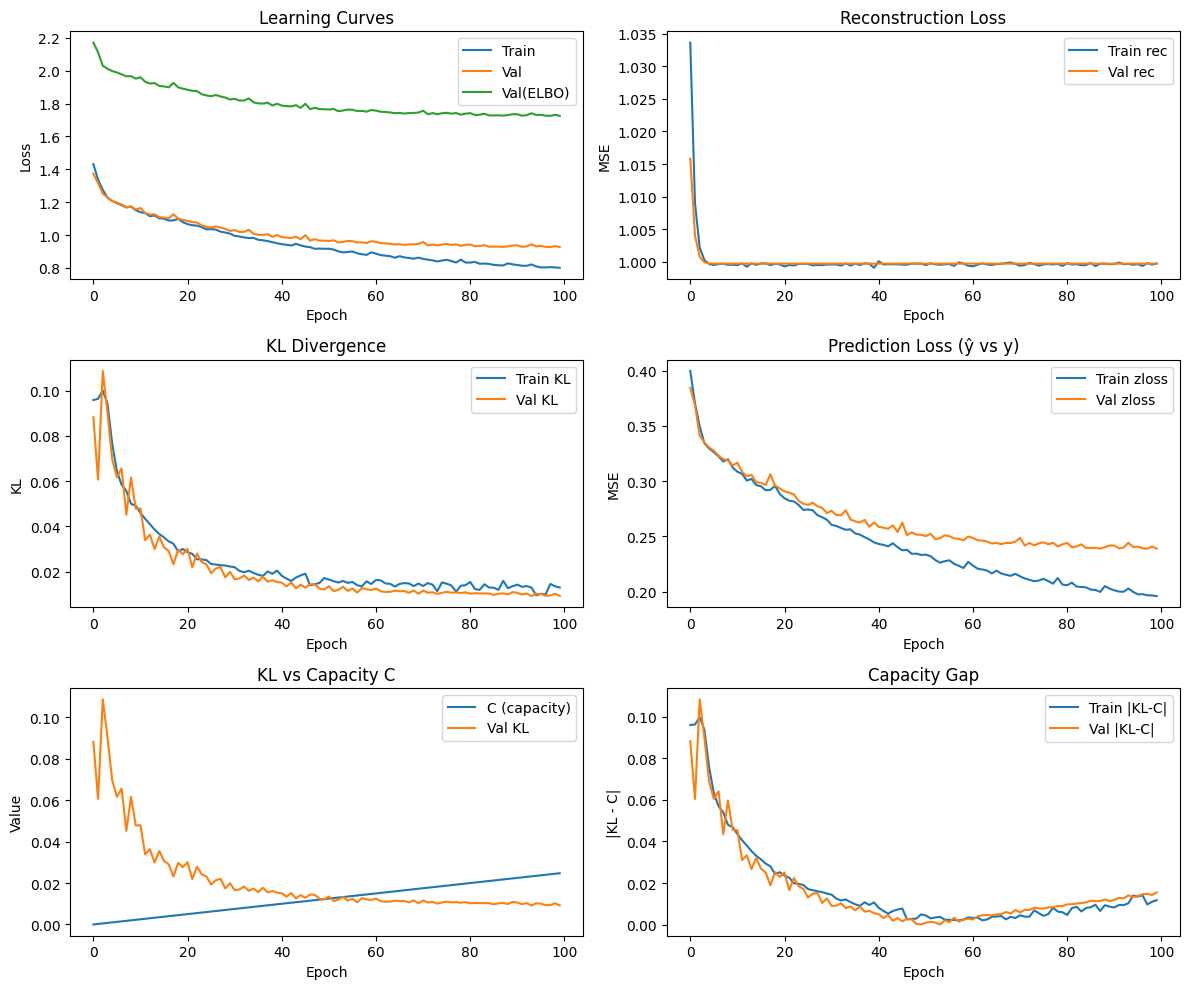

In [17]:
plot_all_curves(
    train_hist,
    val_hist,
    elbo_val_hist,
    train_rec_hist,
    val_rec_hist,
    train_kl_hist,
    val_kl_hist,
    train_z_hist,
    val_z_hist,
    C_values,
    train_capgap_hist,
    val_capgap_hist,
)

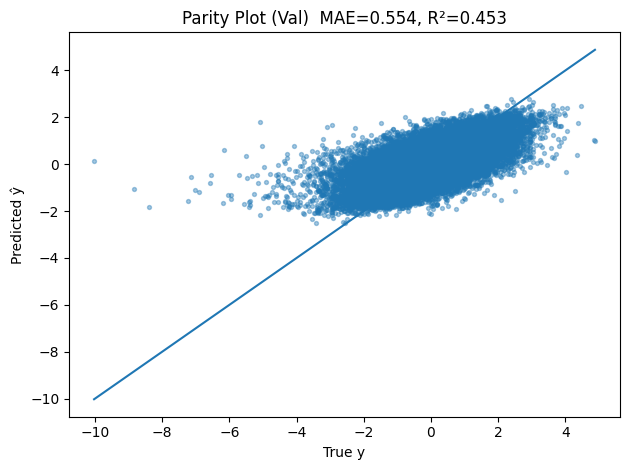

In [26]:
state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.eval()  # 評価モード

eval_dl = torch.utils.data.DataLoader(
    val_ds,  # 元の val_ds でOK
    batch_size=8192,  # 好きなサイズ
    shuffle=False,
    num_workers=0,  # ★シングルプロセス
    pin_memory=False,  # ★不要
    persistent_workers=False,  # ★絶対 False
    drop_last=False,
)

ys, yhats = [], []
with torch.inference_mode():
    for xg, xd, y in eval_dl:
        xg, xd = xg.to(device), xd.to(device)
        _, _, _, yhat = model(xg, xd)
        ys.append(y.cpu().numpy())
        yhats.append(yhat.cpu().numpy())
ys = np.concatenate(ys)
yhats = np.concatenate(yhats)
mae = mean_absolute_error(ys, yhats)
r2 = r2_score(ys, yhats)

plt.figure()
plt.scatter(ys, yhats, s=8, alpha=0.4)
lims = [min(ys.min(), yhats.min()), max(ys.max(), yhats.max())]
plt.plot(lims, lims)
plt.xlabel("True y")
plt.ylabel("Predicted ŷ")
plt.title(f"Parity Plot (Val)  MAE={mae:.3f}, R²={r2:.3f}")
plt.tight_layout()
plt.show()

# How to eval from loading the model

In [19]:
# # 1. Build the model and load the trained weights
# model = GeneDrugVAE(gene_dim, drug_dim=768, proj_dim=256, hidden=512, latent=128).to(device)
# model.load_state_dict(torch.load("models/gdsc/gdsc_last.pt", map_location=device))
# model.eval()  # set to evaluation mode

# # 2. Extract latent representations (μ) for all samples
# mus = []
# with torch.no_grad():  # disable gradient computation
#     for xg, xd, _ in dl:   # ignore y (IC50), only need xg and xd
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, lv = model.encode(xg, xd)   # encode gene + drug into latent space
#         mus.append(mu.cpu().numpy())    # collect μ on CPU

# # Concatenate all latent vectors into one array
# Z_mu = np.concatenate(mus, axis=0)
# print("Latent shape:", Z_mu.shape)

In [20]:
# # ---------- 1) 全サンプルの μ をバッチで抽出 ----------
# model.eval()
# mus = []
# with torch.no_grad():
#     # 推論用 DataLoader（shuffle=False）
#     infer_dl = DataLoader(ds, batch_size=8192, shuffle=False, num_workers=0)
#     for xg, xd, y in tqdm(infer_dl, desc="Encode (μ)", leave=False):
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, logvar = model.encode(xg, xd)  # GeneDrugVAE で encode を実装している前提
#         mus.append(mu.cpu().numpy())

# Z_mu = np.concatenate(mus, axis=0)  # (N, latent)

In [21]:
# # 可視化用メタ：薬ラベル & Z_score（元の ds に対応する順序を確保）
# # cellline_small の順序が ds と一致している前提（Dataset 内でそのまま index を使っている実装ならOK）
# meta_df = cellline_small.reset_index(drop=True).copy()
# # NAME が無い場合は SMILES を代用
# drug_label = meta_df["NAME"] if "NAME" in meta_df.columns else meta_df["SMILES"]
# zscore = meta_df["Z_score"].values
# cellline = meta_df["COSMIC_ID"]

In [22]:
# X0 = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_mu)
# X = (
#     PCA(n_components=min(100, X0.shape[1]), random_state=42)
#     .fit_transform(X0)
#     .astype("float32")
# )

# umap2d = umap.UMAP(
#     n_neighbors=40,
#     min_dist=0.05,
#     metric="cosine",
#     init="spectral",
#     densmap=True,
#     random_state=42,
#     low_memory=True,
#     verbose=True,
# ).fit_transform(X)

In [23]:
# plt.figure()
# sc = plt.scatter(umap2d[:, 0], umap2d[:, 1], s=6, c=zscore, alpha=0.7)
# cb = plt.colorbar(sc)
# cb.set_label("Z_score")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP colored by Z_score")
# plt.tight_layout()
# plt.show()

In [24]:
# # 入力: umap2d (N,2), drug_label (N,), zscore (N,)
# labs = pd.Series(drug_label).astype(str).str.strip().values
# z = np.asarray(zscore, dtype=float)

# # 座標で集約（丸めて同一点判定）
# xy = np.round(umap2d, 6)
# df = pd.DataFrame({"x": xy[:, 0], "y": xy[:, 1], "drug": labs, "z": z})

# # 各座標で「z が最小の薬」を代表に採用（効きが強い薬）
# idx = df.groupby(["x", "y"])["z"].idxmin()
# rep = df.loc[idx].reset_index(drop=True)  # x,y,drug,z が 1行/座標

# # 可視化（Top-20 + Other）
# vc = rep["drug"].value_counts()
# top_k = 20
# top = list(vc.head(top_k).index)

# cmap = plt.colormaps.get_cmap("tab20")
# colors = {d: cmap(i / (top_k - 1)) for i, d in enumerate(top)}
# other_color = (0.5, 0.5, 0.5, 0.25)

# plt.figure(figsize=(9, 7))
# # Otherを下地に
# m_other = ~rep["drug"].isin(top)
# plt.scatter(
#     rep.loc[m_other, "x"],
#     rep.loc[m_other, "y"],
#     s=6,
#     alpha=0.30,
#     color=other_color,
#     rasterized=True,
#     zorder=1,
#     label="Other",
#     edgecolors="none",
# )
# # Top-20 を重ねる
# for d in top:
#     m = rep["drug"].values == d
#     if m.any():
#         plt.scatter(
#             rep.loc[m, "x"],
#             rep.loc[m, "y"],
#             s=12,
#             alpha=0.95,
#             color=colors[d],
#             label=d,
#             rasterized=True,
#             zorder=3,
#             edgecolors="none",
#         )

# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP – winner-takes-all by drug (min Z_score)")
# plt.legend(
#     bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, frameon=False, ncol=2
# )
# plt.tight_layout()
# plt.show()

In [25]:
# labs = pd.Series(drug_label).astype(str).str.strip().values
# drug = "Cisplatin"  # 例

# m = labs == drug
# plt.figure(figsize=(7, 6))
# plt.hexbin(umap2d[m, 0], umap2d[m, 1], gridsize=80, mincnt=1, norm=LogNorm())
# cb = plt.colorbar()
# cb.set_label("count (log)")
# plt.title(f"UMAP density – {drug}")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.tight_layout()
# plt.show()